# Project: 2 and 3 assets portfolio analysis with real returns


- Author: Elena Lopez
- Date: May 28, 2020


## Objective

To conduct 2-asset portfolio analysis with real returns and 3-asset portfolio analysis with real returns to make final recommendations to investors with different risk tolerance. 

## Steps

### Part 1: 2-asset portfolio analysis with real returns
The analysis is conducted using annual real returns on investments in two assets: S&P 500 (including dividends) and US T. Bond.

The following steps were undertaken:
- Adjusting nominal returns to real returns
- Conducting EDA --> Calculate statistics for raw real returns and statistics for excess returns
- Assessing Asset Allocation
- Calculating Minimum Variance Portfolio
- Calculating Maximum Sharpe Ratio Portfolio

### Part 2: 3-asset portfolio analysis with real returns

Same steps were undertaken to conduct this analysis.
Additionally, the efficient fronter was calculated by using brute force with scalability of using N assets. 
In order to identify optimal portfolios, two models were developed that apply brute force: 
- Model I: calculated the 66 different possible combinations with 10% increment for each asset.
- Model II:  calculated 1000 different weight combinations to find the best portfolio with Minimum Variance and Maximum Sharpe Ratio.


## Data set

Data obtained from Aswath Damodoran. It can be downloaded in the following link: http://www.stern.nyu.edu/~adamodar/pc/datasets/histimpl.xls // sheet: Returns by year. 
The excel file was transformed into csv file (uploaded in the folder for direct use).

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
import os
os.getcwd()

'/Users/elenalopez/Desktop/Projects/Python/Uploaded in Github/Financial Analysis/Asset portfolio analysis'

# Create Directory

In [2]:
import os
from os import path
if not os.path.exists('fig'):
    os.mkdir('fig')

# Import Dataset

In [5]:
raw = pd.read_csv("Data_class.csv", index_col=0)

#pd.read_excel('dataset/histretSP.xls',
                    #sheet_name='for_python',
                    #index_col='year')
raw.head()

,S&P 500 (includes dividends),3-month T.Bill,US T. Bond
Year,,,
1928,0.438112,0.0308,0.008355
1929,-0.082979,0.0316,0.042038
1930,-0.251236,0.0455,0.045409
1931,-0.438375,0.0231,-0.025589
1932,-0.086424,0.0107,0.087903


In [4]:
def convert_nominal_to_real(nominal_return, inflation):
    real = (1 + nominal_return)/(1+inflation) - 1
    return real

In [5]:
real_return = pd.DataFrame(
    {
        'snp': convert_nominal_to_real(raw['snp'], raw['inflation']),
        't_bill': convert_nominal_to_real(raw['t_bill'], raw['inflation']),
        't_bond': convert_nominal_to_real(raw['t_bond'], raw['inflation']),
        'cor_bond': convert_nominal_to_real(raw['cor_bond'], raw['inflation'])
    },
    index=raw.index)

# Part 1

## Real Return

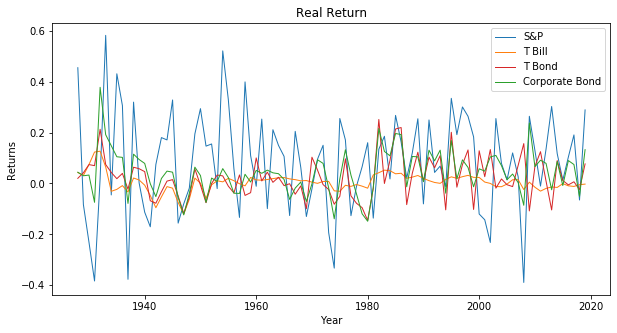

In [6]:
plt.figure(figsize=(10,5))
sns.lineplot(x = real_return.index, y='snp', data=real_return, linewidth = 1, label = 'S&P')
sns.lineplot(x = real_return.index, y='t_bill', data=real_return, linewidth = 1, label = 'T Bill')
sns.lineplot(x = real_return.index, y='t_bond', data=real_return,c = 'C3', linewidth = 1, label = 'T Bond')
sns.lineplot(x = real_return.index, y='cor_bond', data=real_return, linewidth=1, label = 'Corporate Bond')
plt.ylabel('Returns')
plt.title('Real Return')
plt.xlabel('Year')
plt.savefig("fig/real_return_comparison")
plt.show()

In this analysis there are 4 different assets that are used: 
1. US 3-month Treasury Bill or T Bill (Risk-Free asset) 
2. Standard and Poor’s or S&P 500 (stocks)
3. 10-year US Treasury Bond or T Bond
4. Baa Corporate Bond

By looking at the plot, we can observe the differences in returns and the variability of the returns across assets. The plot clearly shows the high volatility of the stocks and the low volatility of the T-Bill. We can observe peaks and troughs of the stocks (blue line in the plot) in contrast to the smooth line of the T-Bill (orange line).

## Real Vs. Nominal Return

### S&P

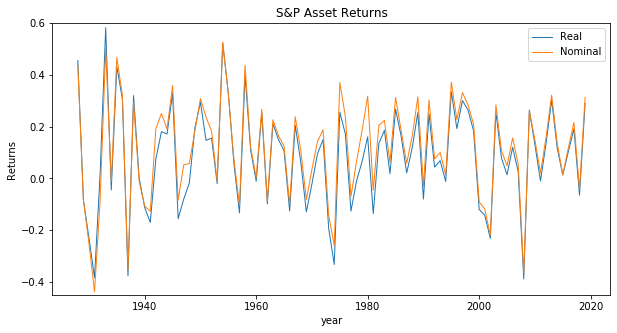

In [7]:
plt.figure(figsize=(10,5))
sns.lineplot(x = real_return.index, y='snp', data=real_return, linewidth = 1, label = 'Real')
sns.lineplot(x = raw.index, y='snp', data=raw, linewidth = 1, label = 'Nominal')
plt.ylabel('Returns')
plt.ylim((-0.45, 0.6))
plt.title('S&P Asset Returns')
plt.savefig('fig/snp_real_nominal.png')
plt.show()

### T Bond

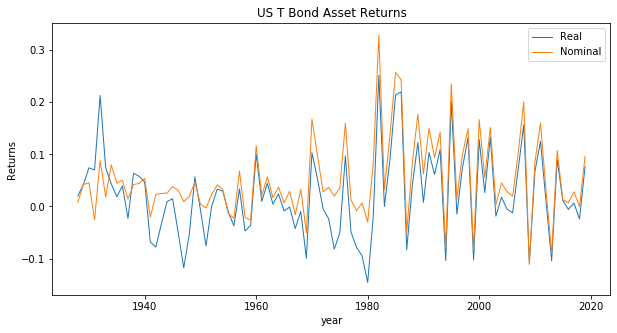

In [8]:
plt.figure(figsize=(10,5))
sns.lineplot(x = real_return.index, y='t_bond', data=real_return, linewidth = 1, label = 'Real')
sns.lineplot(x = raw.index, y='t_bond', data=raw, linewidth = 1, label = 'Nominal')
plt.ylabel('Returns')
plt.title('US T Bond Asset Returns')
plt.savefig('fig/tbond_real_nominal.png')
plt.show()

### T Bill

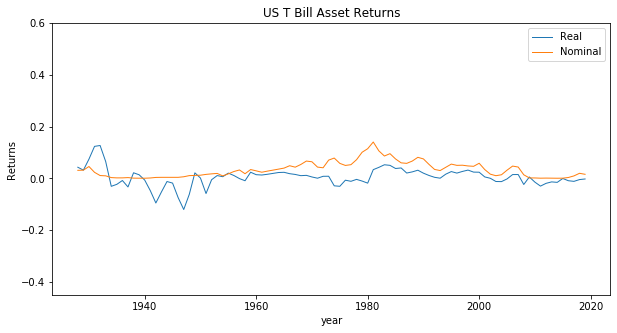

In [9]:
plt.figure(figsize=(10,5))
sns.lineplot(x = real_return.index, y='t_bill', data=real_return, linewidth = 1, label = 'Real')
sns.lineplot(x = raw.index, y='t_bill', data=raw, linewidth = 1, label = 'Nominal')
plt.ylabel('Returns')
plt.ylim((-0.45, 0.6))
plt.title('US T Bill Asset Returns')
plt.savefig('fig/tbill_real_nominal.png')
plt.show()

There is not much difference between real and nominal returns. The effect of inflation on the returns is more visible in graphs of the T-Bond and T-Bill due to their lower returns.

## Excess

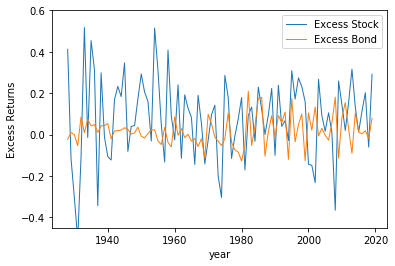

In [10]:
real_return['excess_stock'] = real_return['snp'] - real_return['t_bill']
real_return['excess_bond'] = real_return['t_bond'] - real_return['t_bill']
sns.lineplot(x = real_return.index, y='excess_stock', data=real_return, linewidth = 1, label = 'Excess Stock')
sns.lineplot(x = real_return.index, y='excess_bond', data=real_return, linewidth = 1, label = 'Excess Bond')
plt.ylabel('Excess Returns')
plt.ylim((-0.45, 0.6))
plt.show()

## Statistic

In [11]:
def calculate_autocorrelation(df):
    from scipy.stats import pearsonr
    
    autocorr_list = []
    
    for i in df.columns:
        stock = df[i].dropna()
        corr, pval = pearsonr(stock[:-1], stock[1:])
        autocorr_list.append(corr)
        
    return autocorr_list

In [12]:
def calculate_statistic(stock_panel):
    
    mean = stock_panel.mean()
    variance = stock_panel.var()
    std = stock_panel.std()
    skew = stock_panel.skew()
    kurt = stock_panel.kurt()
    autocorr = calculate_autocorrelation(stock_panel)
    sharpe = mean/std
    
    stat1 = pd.concat([mean, variance, std, skew, kurt, sharpe], axis=1)
    stat1.rename(columns={
        0: 'mean',
        1: 'var',
        2: 'std',
        3: 'skew',
        4: 'kurt',
        5: 'sharpe'
    },
                  inplace=True)
    
    stat2 = pd.DataFrame({'autocorr': autocorr}, index=stock_panel.columns)
    
    output = pd.merge(stat1, stat2, left_index=True, right_index=True)
    
    return output

### Asset Statistics

In [73]:
round(calculate_statistic(real_return),6)

,mean,var,std,skew,kurt,sharpe,autocorr
snp,0.084192,0.038520,0.196266,-0.164416,0.081575,0.428967,-0.026446
t_bill,0.004387,0.001276,0.035718,0.000892,3.594898,0.122827,0.720595
t_bond,0.021719,0.006610,0.081299,0.516695,0.318931,0.267150,0.055985
cor_bond,0.042222,0.007451,0.086317,0.564332,1.770052,0.489148,0.219896
excess_stock,0.079804,0.038654,0.196605,-0.317275,0.241322,0.405912,0.013090
excess_bond,0.017332,0.005140,0.071691,0.381521,0.267866,0.241761,-0.154508
excess_corp,0.037835,0.006027,0.077632,-0.014775,0.551131,0.487360,0.157831


#### Mean
The Stock has on average the highest returns. These higher returns, however, come with some risks. Its standard deviation is the highest, indicating that its variability is much higher. Stocks tend to be a risky asset because the returns depend on a company/index performance (i.e. increase/decrease in equity or dividend payments).
T-Bill has the lowest average return. Due to the lower risk associated with this asset, it provides a much lower return than stocks or T-Bond with an average return that is close to zero.
T-Bond is placed in between Stock and T-Bill in terms of its average return and standard deviation.

#### Skewness
The skewness of the T-Bill and stocks is close to zero (between -0.5 and 0.5). It means that their distribution is approximately symmetric. The return of the T-Bill does not tend to be affected much by economic data. Although portfolio returns tend to be left-skewed, in this case the performance of the index S&P 500 follows a symmetric distribution.
The skewness of the T-Bond indicates that the distribution is moderately and positively skewed. Investors usually prefer positively skewed returns.

#### Kurtosis
Kurtosis of the three assets are between 0 and 3, indicating that the tails of their distribution are generally less extreme than the tails of the normal distribution. This means that they did not experience many extreme returns during the period analyzed.

#### Sharpe ratio
In terms of the Sharpe ratio, the stocks have the highest ratio while the T-Bill has the lowest. It shows that investors in stocks are better rewarded (higher returns) for the extra risk that they have to assume when they invest in these types of assets.

## Different Allocation Strategy

In [14]:
percent_array = list(np.arange(0, 1.1, 0.1).round(1))
percent_array

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [15]:
def calculate_allocation_with_weight(dtframe, percentage_list):
    for percent in percent_array:
        dtframe[str(percent)] = dtframe.iloc[:,0]*percent + dtframe.iloc[:,1]*(1-percent)
        
    return dtframe
    

In [16]:
stock_bond_allo = calculate_allocation_with_weight(real_return.iloc[:, 4:6], percent_array).iloc[:, 2:]
stock_bond_allo.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
year,,,,,,,,,,,
1928,-0.022706,0.020769,0.064245,0.107721,0.151196,0.194672,0.238148,0.281623,0.325099,0.368574,0.412050
1929,0.010438,-0.002064,-0.014565,-0.027067,-0.039569,-0.052071,-0.064572,-0.077074,-0.089576,-0.102078,-0.114579
1930,-0.000093,-0.030572,-0.061050,-0.091528,-0.122007,-0.152485,-0.182963,-0.213442,-0.243920,-0.274398,-0.304877
1931,-0.053463,-0.098789,-0.144115,-0.189442,-0.234768,-0.280094,-0.325421,-0.370747,-0.416073,-0.461400,-0.506726
1932,0.086068,0.066634,0.047199,0.027765,0.008330,-0.011104,-0.030538,-0.049973,-0.069407,-0.088842,-0.108276


In [17]:
# fig, axes = plt.subplots(3, 4, figsize = (20,10))
# plot_df = stock_bond_allo.iloc[:, 2:]
# for i, ax in enumerate(axes.flatten()[:len(plot_df.columns)]):
#     sns.lineplot(x=plot_df.index, y=plot_df.iloc[:,i], ax=ax)

In [18]:
stock_bond_allo_stat = calculate_statistic(stock_bond_allo)
round(stock_bond_allo_stat,4)

,mean,var,std,skew,kurt,sharpe,autocorr
0.0,0.0173,0.0051,0.0717,0.3815,0.2679,0.2418,-0.1545
0.1,0.0236,0.0046,0.0677,0.2471,0.0548,0.3481,-0.1064
0.2,0.0298,0.0049,0.0700,0.0310,-0.0610,0.4258,-0.0452
0.3,0.0361,0.0061,0.0780,-0.1536,0.0013,0.4623,0.0012
0.4,0.0423,0.0081,0.0902,-0.2576,0.1106,0.4691,0.0243
0.5,0.0486,0.0111,0.1052,-0.3035,0.1861,0.4619,0.0316
0.6,0.0548,0.0148,0.1218,-0.3203,0.2248,0.4499,0.0311
0.7,0.0611,0.0195,0.1396,-0.3244,0.2409,0.4373,0.0273
0.8,0.0673,0.0250,0.1582,-0.3235,0.2455,0.4256,0.0225
0.9,0.0736,0.0314,0.1772,-0.3206,0.2446,0.4151,0.0177


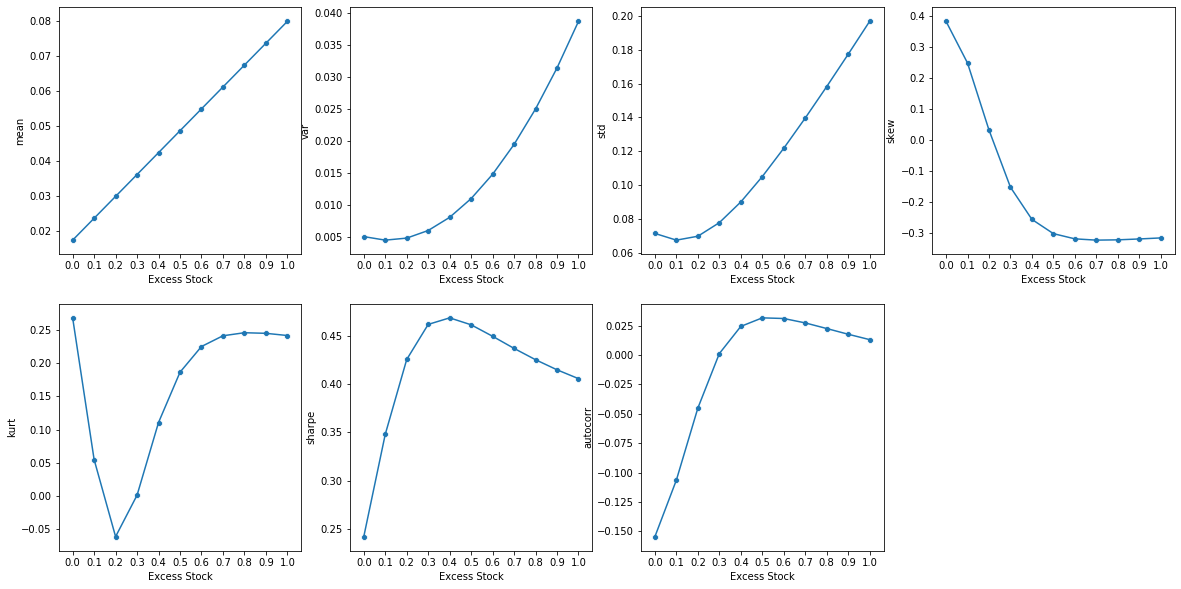

In [19]:
fig, axes = plt.subplots(2, 4, figsize = (20,10))
for i, ax in enumerate(axes.flatten()[:len(stock_bond_allo_stat.columns)]):
    sns.lineplot(x=stock_bond_allo_stat.index, 
                 y=stock_bond_allo_stat.iloc[:,i].values, ax=ax)
    sns.scatterplot(x=stock_bond_allo_stat.index, 
                 y=stock_bond_allo_stat.iloc[:,i].values, ax=ax)
    ax.set(xlabel = 'Excess Stock', ylabel = '{}'.format(stock_bond_allo_stat.columns[i]))

fig.delaxes(axes[1,3])
plt.savefig("fig/two_asset_stats.png",pad_inches = 0.02, bbox_inches='tight', dpi = 300)

The graphs show how Variance varies as the proportion of stock increases. The variance started at 0.051 when the allocation is 0% stock and 100% T bond. The variance is then decreased as the amount of stock increases to 10% and 20% and rapidly increases again as this proportion is pushed even further.

# Part 2

In [20]:
repeated_array = np.repeat(percent_array, 11)

repeat_list = []
for i in np.arange(0, 11):
    repeat_list.extend(percent_array)

grid_df = pd.DataFrame({
    'stock': repeated_array,
    'bond':repeat_list
})
grid_df['sum'] = grid_df['stock'] + grid_df['bond']
grid_df_filter = grid_df[grid_df['sum'] <= 1]
grid_df_filter['corp'] = 1 - (grid_df_filter['stock'] + grid_df_filter['bond'])
grid = round(grid_df_filter.drop(['sum'], axis = 1),1).reset_index()
grid

,index,stock,bond,corp
0,0,0.0,0.0,1.0
1,1,0.0,0.1,0.9
2,2,0.0,0.2,0.8
3,3,0.0,0.3,0.7
4,4,0.0,0.4,0.6
...,...,...,...,...
61,89,0.8,0.1,0.1
62,90,0.8,0.2,0.0
63,99,0.9,0.0,0.1
64,100,0.9,0.1,0.0


In [21]:
real_return['excess_corp'] = real_return['cor_bond'] - real_return['t_bill']
real_return

,snp,t_bill,t_bond,cor_bond,excess_stock,excess_bond,excess_corp
year,,,,,,,
1928,0.454842,0.042792,0.020086,0.044204,0.412050,-0.022706,0.001412
1929,-0.082979,0.031600,0.042038,0.030179,-0.114579,0.010438,-0.001421
1930,-0.230696,0.074181,0.074087,0.032978,-0.304877,-0.000093,-0.041202
1931,-0.383305,0.123422,0.069959,-0.074127,-0.506726,-0.053463,-0.197549
1932,0.018480,0.126756,0.212824,0.377810,-0.108276,0.086068,0.251055
...,...,...,...,...,...,...,...
2015,0.012574,-0.000674,0.011629,-0.008165,0.013248,0.012303,-0.007491
2016,0.103823,-0.009308,-0.005624,0.089918,0.113130,0.003684,0.099226
2017,0.190693,-0.011742,0.006577,0.074355,0.202435,0.018319,0.086097


In [74]:
round(calculate_statistic(real_return),6)

,mean,var,std,skew,kurt,sharpe,autocorr
snp,0.084192,0.038520,0.196266,-0.164416,0.081575,0.428967,-0.026446
t_bill,0.004387,0.001276,0.035718,0.000892,3.594898,0.122827,0.720595
t_bond,0.021719,0.006610,0.081299,0.516695,0.318931,0.267150,0.055985
cor_bond,0.042222,0.007451,0.086317,0.564332,1.770052,0.489148,0.219896
excess_stock,0.079804,0.038654,0.196605,-0.317275,0.241322,0.405912,0.013090
excess_bond,0.017332,0.005140,0.071691,0.381521,0.267866,0.241761,-0.154508
excess_corp,0.037835,0.006027,0.077632,-0.014775,0.551131,0.487360,0.157831


The corporate bond has a higher return than the T-Bill and T-Bond, but lower than the S&P 500. The corporate bond has the same standard deviation as the T-Bond, indicating that they have similar volatility. As the corporate bond has a higher return than the T-Bond, its Sharpe ratio is greater. When comparing across all assets, the corporate bond has the greatest Sharpe ratio. It offers a greater expected return for a relatively lower amount of risk. The skewness shows that the distribution of the corporate bond is moderately skewed, having positively skewed returns.
The kurtosis is below 3, so the tails are less extreme than the tails of the normal distribution. It indicates that there are not extreme returns.

In [23]:
def calculate_3stocks_allo(dataframe, grid, grid_index):
    output = dataframe['excess_stock'] * grid['stock'][grid_index] + dataframe[
        'excess_bond'] * grid['bond'][grid_index] + dataframe['excess_corp'] * grid[
            'corp'][grid_index]
    return output

In [24]:
allocation_grid = pd.DataFrame()
for i in np.arange(len(grid)):
    allocation_grid['st={},bd={}'.format(
        grid['stock'][i],
        grid['bond'][i])] = calculate_3stocks_allo(real_return, grid, i)

In [25]:
statistic_three_assets = calculate_statistic(allocation_grid).reset_index()
statistic_three_assets

,index,mean,var,std,skew,kurt,sharpe,autocorr
0,"st=0.0,bd=0.0",0.037835,0.006027,0.077632,-0.014775,0.551131,0.487360,0.157831
1,"st=0.0,bd=0.1",0.035784,0.005518,0.074284,-0.035013,0.336438,0.481721,0.156806
2,"st=0.0,bd=0.2",0.033734,0.005103,0.071435,-0.039660,0.187254,0.472235,0.148838
3,"st=0.0,bd=0.3",0.031684,0.004781,0.069145,-0.024588,0.102438,0.458223,0.132584
4,"st=0.0,bd=0.4",0.029634,0.004552,0.067471,0.012151,0.068890,0.439203,0.107295
...,...,...,...,...,...,...,...,...
61,"st=0.8,bd=0.1",0.069360,0.026033,0.161348,-0.358133,0.325558,0.429880,0.019080
62,"st=0.8,bd=0.2",0.067310,0.025014,0.158159,-0.323471,0.245524,0.425584,0.022539
63,"st=0.9,bd=0.0",0.075607,0.032588,0.180521,-0.350944,0.317299,0.418828,0.013691
64,"st=0.9,bd=0.1",0.073557,0.031400,0.177202,-0.320630,0.244625,0.415105,0.017673


In [26]:
statistic_three_assets[['mean']].sort_values(by = 'mean', ascending = False).head()

,mean
65,0.079804
63,0.075607
64,0.073557
60,0.071410
61,0.069360


In [27]:
statistic_three_assets[['var']].sort_values(by = 'var', ascending = False).head()

,var
65,0.038654
63,0.032588
64,0.031400
60,0.027145
61,0.026033


In [28]:
statistics_concatenated = pd.concat([grid, statistic_three_assets], axis = 1)
statistics_concatenated

,index,stock,bond,corp,index,mean,var,std,skew,kurt,sharpe,autocorr
0,0,0.0,0.0,1.0,"st=0.0,bd=0.0",0.037835,0.006027,0.077632,-0.014775,0.551131,0.487360,0.157831
1,1,0.0,0.1,0.9,"st=0.0,bd=0.1",0.035784,0.005518,0.074284,-0.035013,0.336438,0.481721,0.156806
2,2,0.0,0.2,0.8,"st=0.0,bd=0.2",0.033734,0.005103,0.071435,-0.039660,0.187254,0.472235,0.148838
3,3,0.0,0.3,0.7,"st=0.0,bd=0.3",0.031684,0.004781,0.069145,-0.024588,0.102438,0.458223,0.132584
4,4,0.0,0.4,0.6,"st=0.0,bd=0.4",0.029634,0.004552,0.067471,0.012151,0.068890,0.439203,0.107295
...,...,...,...,...,...,...,...,...,...,...,...,...
61,89,0.8,0.1,0.1,"st=0.8,bd=0.1",0.069360,0.026033,0.161348,-0.358133,0.325558,0.429880,0.019080
62,90,0.8,0.2,0.0,"st=0.8,bd=0.2",0.067310,0.025014,0.158159,-0.323471,0.245524,0.425584,0.022539
63,99,0.9,0.0,0.1,"st=0.9,bd=0.0",0.075607,0.032588,0.180521,-0.350944,0.317299,0.418828,0.013691
64,100,0.9,0.1,0.0,"st=0.9,bd=0.1",0.073557,0.031400,0.177202,-0.320630,0.244625,0.415105,0.017673


## Minimum Variance

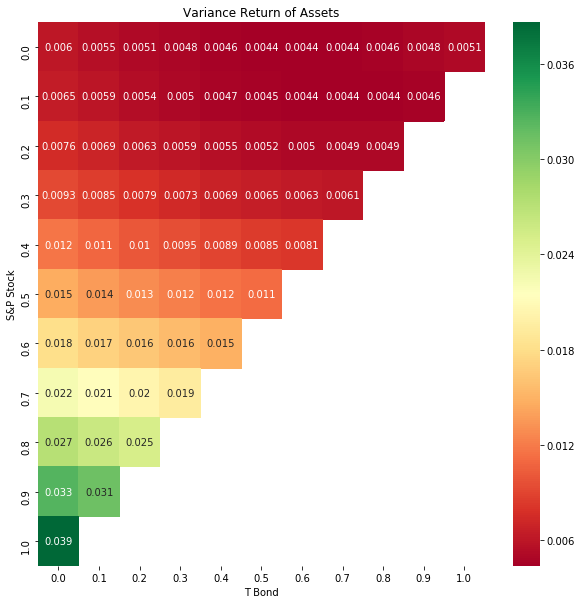

In [29]:
plt.figure(figsize=(10,10))
mean_pivot = statistics_concatenated[['stock', 'bond',
                                      'var']].pivot(index='stock',
                                                     columns='bond',
                                                     values='var')
sns.heatmap(mean_pivot, cmap='RdYlGn', annot=True)
plt.title('Variance Return of Assets')
plt.ylabel('S&P Stock')
plt.xlabel('T Bond')
plt.savefig('fig/heatmap_variance_return.png',bbox_inches='tight', dpi = 300)
plt.show()

The figure above is a grid representation of portfolio composition vs. Variance of Return on Asset. The x-axis represents the percentage of T Bond in the portfolio, the y-axis represents the percentage of S&P Stock in the portfolio and the color spectrum represents the Variance. Since the percentage will need to add up to 100%, the missing percentage will represent the amount of Corporate Bond in the portfolio. For example, T bond = 0.2 and S&P Stock = 0.5 yield to 0.013 Variance. This implies that the same portfolio consists of 30% of Corporate Bond.
The color spectrum helps to categorize the different portfolio based on the variance. It can be observed that the variance increases as the percentage of S&P stock increases and the percentage of T-Bill decreases.


The portfolio with the lowest variance is Portfolio with Stock = 10%, T Bond = 70%, and Corporate Bond = 20% with Variance = 0.004375.

In [66]:
min_var = statistics_concatenated[statistics_concatenated['var'] ==statistics_concatenated['var'].min()]
min_var

,index,stock,bond,corp,index,mean,var,std,skew,kurt,sharpe,autocorr
18,18,0.1,0.7,0.2,"st=0.1,bd=0.7",0.02768,0.004358,0.066013,0.073999,0.024246,0.419305,-0.014795


## Maximum Sharpe

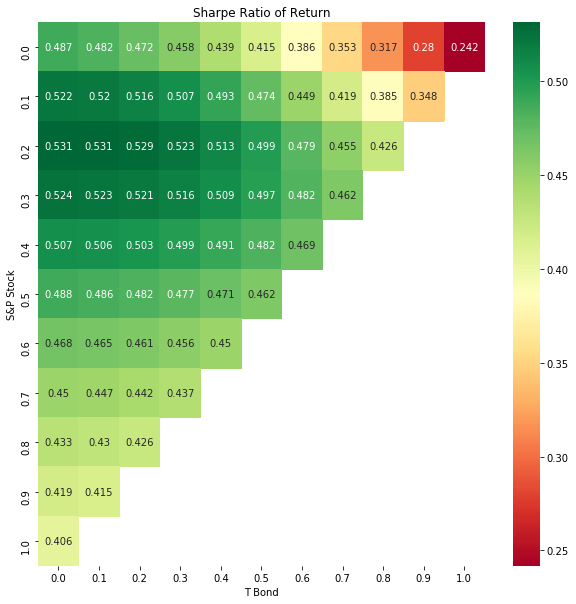

In [30]:
plt.figure(figsize=(10,10))
sharpe_pivot = statistics_concatenated[['stock', 'bond',
                                      'sharpe']].pivot(index='stock',
                                                     columns='bond',
                                                     values='sharpe')
sns.heatmap(sharpe_pivot, cmap='RdYlGn', annot=True, fmt='.3g')
plt.title('Sharpe Ratio of Return')
plt.ylabel('S&P Stock')
plt.xlabel('T Bond')
plt.savefig('fig/heatmap_Sharpe_Ratio_return.png', bbox_inches='tight', dpi = 300)
plt.show()

The heatmap shows the distribution of Sharpe ratio in the scenario of a 3-asset allocation in portfolios. Higher values of Sharpe ratio are in the shades of green color and lower values are in the shades of red color. Another general observation that can be made is that the Sharpe ratio gradually decreases with increase in the stock allocation when it represents below 50% of the portfolio. However, it is the least when the portfolio has 100% bond allocation.
The recommended allocation for the 3 asset portfolio based on maximum Sharpe ratio is Stock = 20%, bond = 10%, corporate bond = 70%.

In [71]:
max_sharpe = statistics_concatenated[statistics_concatenated['sharpe'] ==statistics_concatenated['sharpe'].max()]
max_sharpe

,index,stock,bond,corp,index,mean,var,std,skew,kurt,sharpe,autocorr
22,23,0.2,0.1,0.7,"st=0.2,bd=0.1",0.044178,0.00691,0.083125,-0.501347,0.528048,0.53147,0.091794


# Efficient Frontier

## 2-Assets

In [31]:
def calculate_efficient_frontier(asset1, asset2, weight, covariance):
    expect_asset1 = asset1.mean()
    sigma_asset1 = asset1.std()

    expect_asset2 = asset2.mean()
    sigma_asset2 = asset2.std()

    output = pd.DataFrame({'weight': weight})
    output['covariance'] = covariance
    output['weight2'] = 1 - output['weight']
    output['mean_return'] = expect_asset1 * output[
        'weight'] + expect_asset2 * output['weight2']
    output['term_1'] = (output['weight']**2) * (sigma_asset1**2)
    output['term_2'] = (output['weight2']**2) * (sigma_asset2**2)
    output['term_cov'] = 2 * output['weight'] * output[
        'weight2'] * covariance * sigma_asset1 * sigma_asset2
    output['stdev'] = np.sqrt(output['term_1'] + output['term_2'] +
                              output['term_cov'])

    return output[['weight', 'covariance', 'mean_return', 'stdev']]


efficient_2asset = calculate_efficient_frontier(real_return['snp'],
                                                real_return['t_bond'],
                                                percent_array, 0.1)
efficient_2asset

,weight,covariance,mean_return,stdev
0,0.0,0.1,0.021719,0.081299
1,0.1,0.1,0.027966,0.077628
2,0.2,0.1,0.034214,0.079256
3,0.3,0.1,0.040461,0.085882
4,0.4,0.1,0.046708,0.096481
5,0.5,0.1,0.052955,0.109910
6,0.6,0.1,0.059203,0.125263
7,0.7,0.1,0.065450,0.141915
8,0.8,0.1,0.071697,0.159461
9,0.9,0.1,0.077944,0.177636


In [32]:
for i in percent_array:
    x_new = calculate_efficient_frontier(real_return['snp'], real_return['t_bond'], percent_array, i)
    efficient_2asset.append(x_new, ignore_index=True)

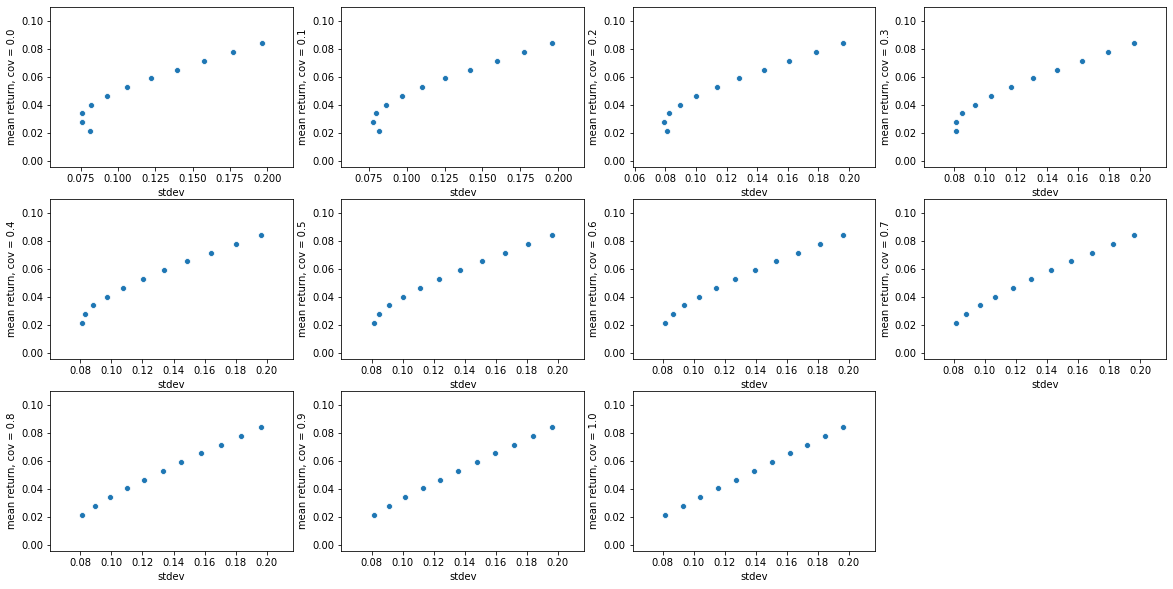

In [33]:
fig, axes = plt.subplots(3,4, figsize = (20,10))
for i, ax in enumerate(axes.flatten()[:len(percent_array)]):
    to_plot = calculate_efficient_frontier(real_return['snp'], real_return['t_bond'], percent_array, i/10)
    sns.scatterplot(x=to_plot['stdev'], y=to_plot['mean_return'], ax=ax)
    ax.set(ylabel = 'mean return, cov = {}'.format(i/10))
fig.delaxes(axes[2,3])

##  3-Assets

In [35]:
weight_3asset = [min_var['stock'].iloc[0], min_var['bond'].iloc[0], min_var['corp'].iloc[0]]
weight_3asset

[0.1, 0.7, 0.2]

In [36]:
def calc_efficient_front_3assets(asset_df, actual_weight, weight):

    asset1 = asset_df.iloc[:, 0]
    asset2 = asset_df.iloc[:, 1]
    asset3 = asset_df.iloc[:, 2]

    exp_ass1 = asset1.mean()
    exp_ass2 = asset2.mean()
    exp_ass3 = asset3.mean()

    sigma_ass1 = asset1.std()
    sigma_ass2 = asset2.std()
    sigma_ass3 = asset3.std()

    cov12 = np.cov(asset1, asset2)
    cov13 = np.cov(asset1, asset3)
    cov23 = np.cov(asset2, asset3)
    
    weight['w1'] = weight.iloc[:, 0]*actual_weight[0]
    weight['w2'] = weight.iloc[:, 1]*actual_weight[1]
    weight['w3'] = weight.iloc[:, 2]*actual_weight[2]

    

    return weight


calc_efficient_front_3assets(real_return[['snp', 't_bond', 'cor_bond']],
                             weight_3asset, grid.drop('index', axis=1))

,stock,bond,corp,w1,w2,w3
0,0.0,0.0,1.0,0.00,0.00,0.20
1,0.0,0.1,0.9,0.00,0.07,0.18
2,0.0,0.2,0.8,0.00,0.14,0.16
3,0.0,0.3,0.7,0.00,0.21,0.14
4,0.0,0.4,0.6,0.00,0.28,0.12
...,...,...,...,...,...,...
61,0.8,0.1,0.1,0.08,0.07,0.02
62,0.8,0.2,0.0,0.08,0.14,0.00
63,0.9,0.0,0.1,0.09,0.00,0.02
64,0.9,0.1,0.0,0.09,0.07,0.00


In [37]:
weight_3asset
weights_array = np.array(weight_3asset)
weights_array

array([0.1, 0.7, 0.2])

# PyPortfolioOpt Method

In [38]:
port = real_return[['snp', 't_bond', 'cor_bond']]
por_cov = port.cov()
port_variance = np.dot(weights_array.T, np.dot(por_cov, weight_3asset))
round(port_variance, 5)

0.00566

In [39]:
port.mean()

snp         0.084192
t_bond      0.021719
cor_bond    0.042222
dtype: float64

In [40]:
port_volatility = np.sqrt(port_variance)
round(port_volatility,5)

0.07522

In [41]:
# Calculate the anual porfolio return
portfolioSimpleAnnRet = np.sum(port.mean()*weights_array)
portfolioSimpleAnnRet

0.032066850962864435

In [42]:
pip install PyPortfolioOpt

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [43]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [44]:
# Portfolio Optimization
# Calculate the expected returns

mu = port.mean()
S = port.cov()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

In [45]:
cleaned_weights

{'snp': 0.45202, 't_bond': 0.0, 'cor_bond': 0.54798}

In [46]:
ef.portfolio_performance(verbose=True)

Expected annual return: 6.1%
Annual volatility: 11.7%
Sharpe Ratio: 0.35


(0.06119269804153607, 0.11738999129403975, 0.35090468605927516)

# FinQuest Method

source: [source](https://www.youtube.com/watch?v=KDabodOhon8&list=PLLVfjXL2pnkQQXmBMPu_NIst57AKak5Z1&index=11)

In [47]:
port.head()

,snp,t_bond,cor_bond
year,,,
1928,0.454842,0.020086,0.044204
1929,-0.082979,0.042038,0.030179
1930,-0.230696,0.074087,0.032978
1931,-0.383305,0.069959,-0.074127
1932,0.018480,0.212824,0.377810


In [48]:
por_cov

,snp,t_bond,cor_bond
snp,0.038520,0.000888,0.007414
t_bond,0.000888,0.006610,0.004698
cor_bond,0.007414,0.004698,0.007451


In [49]:
num_assets = len(port.columns)

In [50]:
# Create 3 random values
random_values = np.random.random(num_assets);random_values

array([0.70371991, 0.26527211, 0.71462638])

In [51]:
# Normalize values, so they add up to 1
random_weights = random_values/np.sum(random_values)
random_weights

array([0.41798065, 0.15756071, 0.42445864])

In [52]:
NUM_PORTFOLIO = 1000
np.random.seed(69)
# Create container list
port_ret_list = []
port_volatility_list = []
port_weights_list = []
list_var = []
list_sharpe = []
list_asset1 = []
list_asset2 = []
list_asset3 = []

for porfolio in range(NUM_PORTFOLIO):
    
    # Create 3 random values
    random_values = np.random.random(num_assets)
    
    # Normalize values, so they add up to 1
    random_weights = random_values/np.sum(random_values)
    
    # Store weights
    list_asset1.append(random_weights[0])
    list_asset2.append(random_weights[1])
    list_asset3.append(random_weights[2])
    
    # Calculate Return and store
    returns = np.dot(random_weights, mu)
    port_ret_list.append(returns)
    
    # Calculate Variance
    # First mul is multiplying the covariance matrix with weights across the rows
    # Second mul is multiplying  the covariance matrix with weight across colums
    # sum all of this numbers
    var = por_cov.mul(random_weights, axis = 0).mul(random_weights, axis = 1).sum().sum()
    list_var.append(var)
    
    std = np.sqrt(var)
    port_volatility_list.append(std)
    
    sharpe = returns/std
    list_sharpe.append(sharpe)
    
fin_method_result = pd.DataFrame({
    'snp': list_asset1,
    't_bond': list_asset2,
    'cor_bond': list_asset3,
    'returns': port_ret_list,
    'std/volatility': port_volatility_list,
    'variance': list_var,
    'sharpe': list_sharpe
})

fin_method_result

,snp,t_bond,cor_bond,returns,std/volatility,variance,sharpe
0,0.203528,0.555843,0.240629,0.039368,0.079076,0.006253,0.497844
1,0.492044,0.349892,0.158064,0.055699,0.110906,0.012300,0.502220
2,0.125461,0.069868,0.804671,0.046055,0.086623,0.007504,0.531670
3,0.314552,0.330308,0.355140,0.048651,0.091735,0.008415,0.530346
4,0.067287,0.279875,0.652838,0.039308,0.079177,0.006269,0.496449
...,...,...,...,...,...,...,...
995,0.465947,0.236865,0.297188,0.056921,0.110917,0.012303,0.513186
996,0.310482,0.226229,0.463290,0.050614,0.094303,0.008893,0.536717
997,0.192568,0.173740,0.633692,0.046742,0.086736,0.007523,0.538896
998,0.643656,0.113606,0.242737,0.066907,0.138523,0.019189,0.483000


In [53]:
max_sharpe = fin_method_result['sharpe'].max()
min_var = fin_method_result['variance'].min()

In [62]:
# Max Sharpe
fin_method_result[fin_method_result['sharpe'] == max_sharpe]

,snp,t_bond,cor_bond,returns,std/volatility,variance,sharpe
70,0.239488,0.024586,0.735926,0.051769,0.09509,0.009042,0.544418


In [60]:
# Min Variance
fin_method_result[fin_method_result['variance'] == min_var]

,snp,t_bond,cor_bond,returns,std/volatility,variance,sharpe
936,0.089878,0.619616,0.290506,0.03329,0.075199,0.005655,0.442694


In [ ]:
#Plot for efficient frontier
#plt.scatter(result_3["Standard deviation"], result_3["Mean"], c=result_3["Sharpe ratio"], cmap='viridis')
#plt.colorbar(label='Sharpe Ratio')
# plt.figure(figsize=(15,8))
# plt.scatter(x= fin_method_result[['std/volatility']], y= portfolios[['snp']])
# plt.scatter(0.075171,0.032495,c='red', s=120, label= "Min. Variance Portfolio", marker= "o",)
# plt.scatter(0.093076, 0.050647,c='black', s=120, label= "Max. Sharpe Ratio", marker= "o",)
# plt.xlabel('Standard Deviation', fontsize=18)
# plt.ylabel('Return', fontsize=18)
# plt.title('Efficient Frontier', fontsize= 18)
# plt.legend(loc=2, prop={'size': 16})
# plt.show()

# Final findings and recommendations

## Recommendation on model

Model II - FinQuest Method is preferable because it allows  to compare a higher number of portfolio combinations and thus the portfolio can be better optimized. It is also more flexible, as I can input the number of different portfolios we want to calculate and the number of assets in the portfolio.


## Recommendation on investment portfolio

To recommend the investor to build a portfolio with 3 assets (Stock, T- Bond and Corporate Bond) and their allocation done based on the maximum Sharpe ratio using the brute force method with scalability - Stock 23.95%, T Bond 2.46%, Corporate Bond 73.59%. Conversely, if the investor wants a 3-asset portfolio with least risk involved, they can choose the portfolio with 6.6% risk and allocation as follows - Stock 10%, T Bond 70%, Corporate Bond 20%.
The best portfolio based on the Sharpe ratio has the least weight on T Bond and maximum weight on Corporate bond because the Corporate bond rewards the investor better. It yields a higher return for the risk involved.
Overall, a 3-asset portfolio has higher returns as compared to the 2-asset portfolio. A higher number of assets in a portfolio can help an investor to achieve diversification benefits easily.